In [2]:
# P = '/home/jovyan/rmt/babilong-ru/data/babilong-ru/data/qa1/1k.json'
# with open(P, 'r') as f:
#     d = json.load(f)

In [3]:
import os
os.chdir('..')

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from tqdm.auto import tqdm
import pandas as pd
import time
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
# from babilong.babilong_utils import compare_answers
from babilong.metrics import compare_answers, TASK_LABELS

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

## Evaluate result

In [4]:


# import os
# os.chdir('..')

In [5]:
# ls /home/jovyan/kuratov/models/gigar-7b-32k-pretrain/evaluation_results/babilong_results/

In [6]:
# results_folder = '/home/jovyan/kuratov/models/'
results_folder = "/home/jovyan/rmt/babilong/babilong_evals"
# results_folder = "/home/jovyan/rmt/babilong-dataset-release/babilong_evals"

In [7]:
# model_names = ["01-ai/Yi-9B-200k", "mistralai/Mistral-7B-Instruct-v0.2", "microsoft/Phi-3-medium-128k-instruct", 'gpt2', 'mistralai/Mistral-7B-Instruct-v0.2-qa1', 'mistralai/Mistral-7B-Instruct-v0.2-qa2']
# results_folder = '../babilong_evals'

# find all model names in the results folder
model_names = []
model_dirs = next(os.walk(results_folder))[1]
for mn in model_dirs:
    mn_dir = os.path.join(results_folder, mn)
    subdirs = next(os.walk(mn_dir))[1]
    if len(subdirs) == 0:
        model_names.append(mn)
    else:
        for sd in subdirs:
            model_names.append(f"{mn}/{sd}")

print(model_names)

['gigar-7b-8k-pretrain', 'llama3.2-1b', 'gigar-7b-32k-pretrain', 'gigaseek-20b-8k-pretrain', 'llama3.2-1b-instruct', 'gigaseek-20b-32k-pretrain', 'test/home', 'test/armt-llama3.2-1b-8x1024-ct-v3-retrain-align_right-prompt-v2-test', 'test/rmt-llama3.2-1b-', 'test/armt-llama3.2-1b-2x1024-ct-v3-lora-rlls-eval-ells', 'test/armt-llama3.2-1b-2x1024-ct-v3-rlls', 'test/armt-llama3.2-1b-2x1024-ct-v3-lora-rlls-eval-rlls-2', 'test/armt-llama3.2-1b-2x1024-ct-v3-lora-rlls-eval-ells-2', 'test/armt-llama3.2-1b-2x1024-ct-v3-lora-rlls-eval-ells-2-2k_iter', 'test/armt-llama3.2-1b-2x1024-ct-v3-lora-rlls-eval-rlls-2-2k_iter', 'test/armt-llama3.2-1b-4x1024-ct-v3-lora-rlls-eval-ells', 'correction_fail/armt-llama3.2-1b-1x1024-ct-v3-full-align_right-prompt-v2', 'correction_fail/armt-llama3.2-1b-1x1024-ct-v3-retrain-align_right', 'correction_fail/armt-llama3.2-1b-1x1024-ct-v3-retrain-align_right-canonic', 'correction_fail/armt-llama3.2-1b-1x1024-ct-v3-retrain-align_right-prompt-v2', 'correction_fail/armt-llama

In [8]:
# model_names = ["gigar-7b-8k-pretrain/evaluation_results/babilong_results/", "gigar-7b-32k-pretrain/evaluation_results/babilong_results/", "gigaseek-20b-8k-pretrain/evaluation_results/babilong_results/", "gigaseek-20b-32k-pretrain/evaluation_results/babilong_results/"]
# model_names = ["gigar-7b-8k-pretrain", "gigar-7b-32k-pretrain"]
# model_names = ["gigar-7b-8k-pretrain"]
# model_names = [ 'GigaR-3.5-7b-32k_v26_8_chatml', 'GigaR-30b-8k-v26_8_chatml',  'GigaR-3.5-7b-32k_v26_8_chatml_no_chat_temp', 'GigaSeek-20b-32k-v26_13_chatml_v2_2']
# model_names = ['rmt-llama3.2-1b-1x1024']


# model_names_init = ['rmt-llama3.2-1b-1x1024-ct-v3', 'rmt-llama3.2-1b-2x1024-ct-v3', 'rmt-llama3.2-1b-4x1024-ct-v3', 'rmt-llama3.2-1b-8x1024-ct-v3']

# model_names = []
# model_names += model_names_init
# model_names += [n + '-vary' for n in model_names_init]
# model_names += [n + '-align_right' for n in model_names_init]


# model_names = [m for m in model_names if 'rmt-llama3.2-1' in m and 'v3' in m and 'fail' not in m]
# model_names = [m for m in model_names if 'llama3.2-1' in m and 'test' not in m and 'fail' not in m]
# model_names = [m for m in model_names if 'llama3.2-1' in m and 'fail' not in m]
# model_names = [m for m in model_names if 'llama3.2-1' in m]# and 'rlls' in m]

# model_names = [m for m in model_names if 'llama3.2-1' in m and 'dolly' in m]
# model_names = [m for m in model_names if 'llama3.2-1' in m and ('dolly' in m or 'smol' in m or 'last' in m)]
model_names = [m for m in model_names if 'llama3.2-1' in m and ('smol' in m or 'last-' in m)]
model_names += ['llama3.2-1b', 'llama3.2-1b-instruct',]

model_names = sorted(model_names)
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5', 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k']#, '32k', '64k']#, "128k"]

In [9]:
model_names

['armt-llama3.2-1b-2x1024-LR1e-05-smol:qa1-5-1:9-distill_1.0-4000',
 'llama3.2-1b',
 'llama3.2-1b-instruct',
 'llama3.2-1b-instruct-fs-last-seg-only-v2',
 'llama3.2-1b-instruct-fs-last-seg-only-v3',
 'llama3.2-1b-instruct-last-seg-x1024-only',
 'llama3.2-1b-instruct-last-seg-x1024-only-aling-left',
 'llama3.2-1b-instruct-last-seg-x1024-only-aling-left-2']

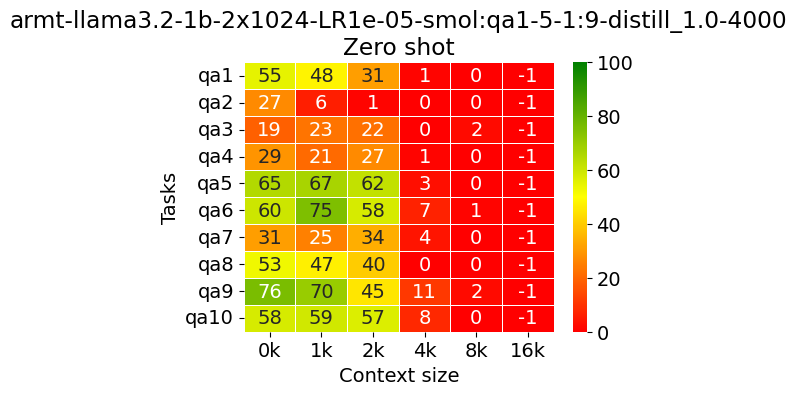

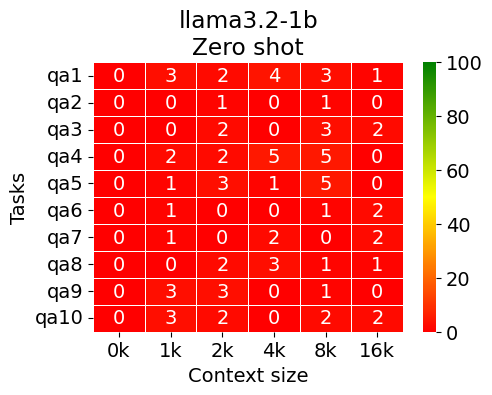

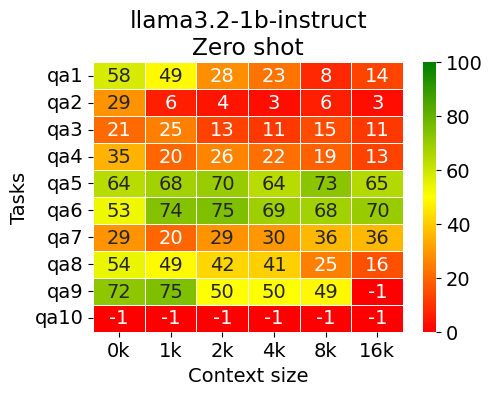

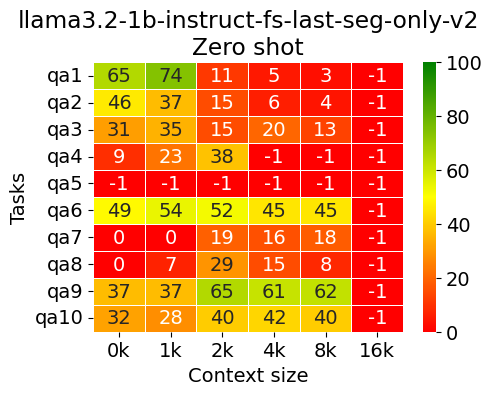

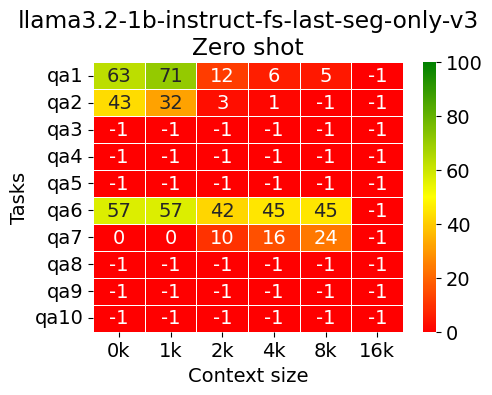

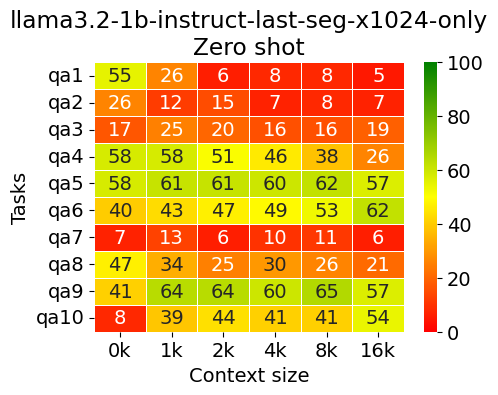

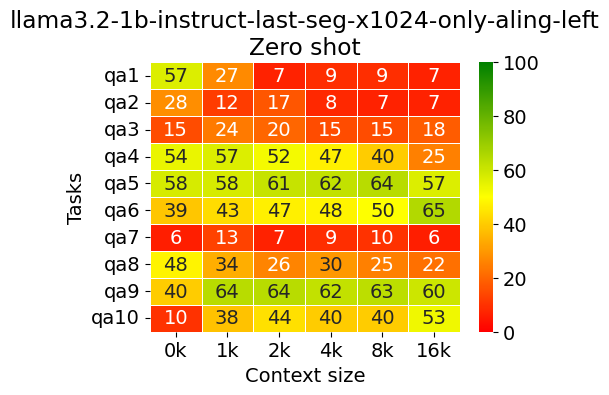

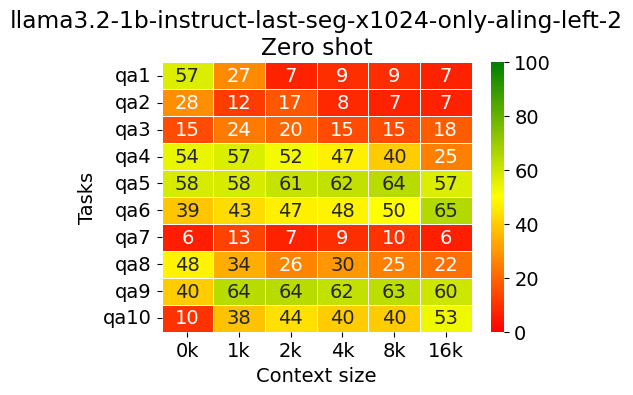

In [11]:
results = {}
# for model_name in sorted(model_names):
for model_name in model_names[:]:
    prompt_name = 'instruction_no_examples_no'
    # accuracy = np.zeros((len(tasks), len(lengths)))
    accuracy = np.ones((len(tasks), len(lengths))) * -1
    try:
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                
                fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}'
                fnames = [f'{fname}_post_prompt_no.csv', f'{fname}_post_prompt_no_chat_template_no.csv', f'{fname}_post_prompt_no_chat_template_yes.csv', f'{fname}_post_prompt_no_chat_template_yes.csv']
                fname = None
                for fn in fnames:
                    if os.path.isfile(fn):
                        fname = fn
                        break
                if not fname:
                    # print(f'No such file: {fn}')
                    continue

                df = pd.read_csv(fname)
                
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'], question=row['question'],
                                                                     task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

        prompt_name = 'instruction_yes_examples_yes'
        # accuracy_fs = np.zeros((len(tasks), len(lengths)))
        accuracy_fs = np.ones((len(tasks), len(lengths))) * -1
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}'
                fnames = [f'{fname}_post_prompt_yes.csv', f'{fname}_post_prompt_yes_chat_template_no.csv', f'{fname}_post_prompt_yes_chat_template_yes.csv',
                          f'{fname}_post_prompt_yes_chat_template_yes_system_prompt_yes.csv']
                fname = None
                for fn in fnames:
                    if os.path.isfile(fn):
                        fname = fn
                if not fname:
                    # print(f'No such file: {fn}')
                    continue
                
                df = pd.read_csv(fname)
                
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'], question=row['question'],
                                                                     task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy_fs[j, i] = 100 * score / len(df) if len(df) > 0 else 0

        results[model_name] = {'zero': accuracy, 'few': accuracy_fs}
        

        # Set large font sizes for better visibility in the PDF
        matplotlib.rc('font', size=14)

        # Create a colormap for the heatmap
        cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

        # Create the heatmap
        # fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))  # Adjust the size as necessary
        
        # # acc_exists = accuracy[:, (accuracy < 0).sum(axis=0) == 0]
        # sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
        #             linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[0])
        
        # # acc_fs_exists = accuracy_fs[:, (accuracy_fs < 0).sum(axis=0) == 0]
        # sns.heatmap(accuracy_fs, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
        #             linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[1])

        # fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))  # Adjust the size as necessary
        
        # # acc_exists = accuracy[:, (accuracy < 0).sum(axis=0) == 0]
        # sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
        #             linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[0])
        
        # # acc_fs_exists = accuracy_fs[:, (accuracy_fs < 0).sum(axis=0) == 0]
        # sns.heatmap(accuracy_fs, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
        #             linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[1])
        
        # # ax[0].set_title(f'Zero shot \n {model_name}')
        # # ax[1].set_title(f'Few shot \n {model_name}')
        # ax[0].set_title(f'{model_name}\nZero shot')
        # # ax[1].set_title(f'Few shot \n {model_name}')
        # ax[1].set_title(f'Few shot')
        # ax[0].set_xlabel('Context size')
        # ax[1].set_xlabel('Context size')
        # ax[0].set_ylabel('Tasks')
        # ax[1].set_ylabel('Tasks')

        fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))  # Adjust the size as necessary
        
        # acc_exists = accuracy[:, (accuracy < 0).sum(axis=0) == 0]
        if accuracy.mean() == -1:
            accuracy = accuracy_fs
        sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
        ax.set_title(f'{model_name}\nZero shot')
        ax.set_xlabel('Context size')
        ax.set_ylabel('Tasks')

        # Save the figure to a PDF
        # plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
        plt.show()
    except KeyError as e:
        print(f"question not found in {model_name}")
        continue
        

### Visualize to copy to table

In [9]:
results.keys()

dict_keys(['GigaR-3.5-7b-32k_v26_8_chatml', 'GigaR-30b-8k-v26_8_chatml', 'GigaR-3.5-7b-32k_v26_8_chatml_no_chat_temp', 'GigaSeek-20b-32k-v26_13_chatml_v2_2'])

In [10]:
res_df = pd.DataFrame()

for mn in results.keys():
    tab = results[mn]['zero']
    tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

    tab_few = results[mn]['few']
    tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

    tab['avg'] = tab.mean(axis=1)
    tab_few['avg'] = tab_few.mean(axis=1)

    best_tab = tab_few.copy()
    for i, row in tab.iterrows():
        if row.avg > best_tab.loc[i].avg:
            best_tab.loc[i] = row

    tab_r = pd.DataFrame(tab.mean(axis=0).astype(int)).T
    tab_fs_r = pd.DataFrame(tab_few.mean(axis=0).astype(int)).T

    tab_r.index = [mn + '_zs']
    tab_fs_r.index = [mn + '_fs']

    res_df = pd.concat([res_df, tab_r, tab_fs_r])

In [1]:
import numpy as np

In [24]:
np.random.random()

0.4379492011871984

In [14]:
res_df

,0k,1k,2k,4k,8k,16k,32k,avg
GigaR-3.5-7b-32k_v26_8_chatml_zs,35,29,38,39,38,39,35,36
GigaR-3.5-7b-32k_v26_8_chatml_fs,66,60,54,45,38,36,33,47
GigaR-30b-8k-v26_8_chatml_zs,47,40,39,40,45,8,0,31
GigaR-30b-8k-v26_8_chatml_fs,65,63,59,51,46,37,0,46
GigaR-3.5-7b-32k_v26_8_chatml_no_chat_temp_zs,58,50,48,47,47,46,42,48
GigaR-3.5-7b-32k_v26_8_chatml_no_chat_temp_fs,59,52,40,31,30,32,34,40
GigaSeek-20b-32k-v26_13_chatml_v2_2_zs,50,40,36,35,33,35,36,38
GigaSeek-20b-32k-v26_13_chatml_v2_2_fs,57,54,52,49,44,45,41,49


### Questions
- how do they go beyond 8k? PE?
    - if so, we should tune the PEs for long contexts
- does the limiataion of len (assert) ruin scores

In [19]:
mn = "GigaR-3.5-7b-32k_v26_8_chatml"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

In [20]:
pd.DataFrame(tab.mean(axis=0).astype(int)).T

,0k,1k,2k,4k,8k,16k,32k,avg
0,58,50,48,47,47,46,42,48


In [21]:
pd.DataFrame(tab_few.mean(axis=0).astype(int)).T

,0k,1k,2k,4k,8k,16k,32k,avg
0,59,52,40,31,30,32,34,40


In [22]:
mn = "GigaR-30b-8k-v26_8_chatml"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

In [23]:
pd.DataFrame(tab.mean(axis=0).astype(int)).T

,0k,1k,2k,4k,8k,16k,32k,avg
0,58,50,48,47,47,-1,-1,35


In [24]:
pd.DataFrame(tab_few.mean(axis=0).astype(int)).T

,0k,1k,2k,4k,8k,16k,32k,avg
0,59,52,40,31,30,25,22,37


In [52]:
# best_tab.round().astype(int)[best_tab.columns[:-1]]

In [14]:
mn = "gigaseek-20b-32k-pretrain"

tab = results[mn]['zero'][:, :]
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

In [15]:
pd.DataFrame(tab.mean(axis=0).astype(int)).T

,0k,1k,2k,4k,8k,16k,32k,avg
0,25,16,18,26,33,36,36,27


In [16]:
pd.DataFrame(tab_few.mean(axis=0).astype(int)).T

,0k,1k,2k,4k,8k,16k,32k,avg
0,24,18,12,12,10,27,35,20


In [12]:
best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,35,13,-1,-1,-1,-1,-1,-1,-1
qa2,21,17,-1,-1,-1,-1,-1,-1,-1
qa3,6,8,-1,-1,-1,-1,-1,-1,-1
qa4,29,18,-1,-1,-1,-1,-1,-1,-1
qa5,45,19,-1,-1,-1,-1,-1,-1,-1


In [13]:
mn = "01-ai/Yi-9B-200k"

tab = results[mn]['zero'][:, :]
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,33,82,69,59,56,47,44,32,29
qa2,67,52,43,39,31,25,22,12,8
qa3,34,33,29,24,25,21,20,20,8
qa4,49,47,50,50,54,43,45,36,33
qa5,76,59,50,57,57,45,52,47,40


In [14]:
mn = "mistralai/Mistral-7B-Instruct-v0.2-qa1"

tab = results[mn]['zero'][:, :]
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,100,100,100,99,99,98,97,-1,-1
qa2,30,30,31,28,24,21,18,-1,-1
qa3,2,2,2,2,2,2,2,-1,-1
qa4,2,1,0,0,0,0,0,-1,-1
qa5,0,0,0,0,0,0,0,-1,-1


In [16]:
mn = "mistralai/Mistral-7B-Instruct-v0.2-qa2"

tab = results[mn]['zero'][:, :]
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,19,14,0,0,0,0,0,-1,-1
qa2,19,13,0,0,0,0,0,-1,-1
qa3,8,8,9,8,10,15,18,-1,-1
qa4,32,17,17,17,16,16,15,-1,-1
qa5,0,0,0,0,0,0,0,-1,-1


In [17]:
df

,Unnamed: 0,target,output,question,correct
0,0,football,garden</s></s>,What did Fred give to Jeff?,False
1,1,Fred,garden</s></s>,Who gave the football to Jeff?,False
2,2,football,garden</s></s>,What did Fred give to Jeff?,False
3,3,Jeff,garden</s></s>,Who did Fred give the football to?,False
4,4,Fred,garden</s></s>,Who did Jeff give the football to?,False
...,...,...,...,...,...
994,994,Jeff,kitchen</s></s>,Who gave the football to Mary?,False
995,995,Bill,garden</s></s>,Who received the football?,False
996,996,Fred,kitchen</s></s>,Who gave the football?,False
997,997,football,garden</s> garden,What did Mary give to Bill?,False


### add questions to csv files

In [25]:
model_names = ["01-ai/Yi-9B-200k", "mistralai/Mistral-7B-Instruct-v0.2", "microsoft/Phi-3-medium-128k-instruct"]
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']#, '64k', "128k"]

In [26]:
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        data = datasets.load_dataset("booydar/babilong-1k-samples", ctx_length)

        for model_name in model_names:
            # print(f"    processing {fname}")
            for prompt_name in ['instruction_no_examples_no_post_prompt_no', 'instruction_yes_examples_yes_post_prompt_yes']:
                fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'

                if not os.path.isfile(fname):
                    # print(f'No such file: {fname}')
                    continue
                df = pd.read_csv(fname)
                # print(fname)

                if 'question' in df.columns:
                    print(f"{fname} already has questions")
                    continue
                
                
                task_data = data[task]
                try:
                    assert (df.target.values == task_data['target'][:df.shape[0]]).all()
                    df['question'] = task_data['question'][:df.shape[0]]
                    df.to_csv(fname, index=False)
                except AssertionError as e:
                    print(f"{fname} has {df.shape} examples")
                
        

/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_0k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_0k_instruction_yes_examples_yes_post_prompt_yes.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/mistralai/Mistral-7B-Instruct-v0.2/qa1_0k_instruction_no_examples_no_post_prompt_no.csv has (100, 3) examples
/home/jovyan/rmt/babilong/babilong_evals_1k/microsoft/Phi-3-medium-128k-instruct/qa1_0k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/microsoft/Phi-3-medium-128k-instruct/qa1_0k_instruction_yes_examples_yes_post_prompt_yes.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_1k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_1k_instruction_yes_examples_yes_post_prompt_yes.csv alr

In [27]:
model_names = ["01-ai/Yi-9B-200k", "mistralai/Mistral-7B-Instruct-v0.2", "microsoft/Phi-3-medium-128k-instruct"]
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['64k', "128k"]

In [28]:
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        data = datasets.load_dataset("booydar/babilong", ctx_length)

        for model_name in model_names:
            # print(f"    processing {fname}")
            for prompt_name in ['instruction_no_examples_no_post_prompt_no', 'instruction_yes_examples_yes_post_prompt_yes']:
                fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'

                if not os.path.isfile(fname):
                    # print(f'No such file: {fname}')
                    continue
                df = pd.read_csv(fname)
                # print(fname)

                if 'question' in df.columns:
                    print(f"{fname} already has questions")
                    continue
                
                
                task_data = data[task]
                try:
                    assert (df.target.values[:task_data.shape[0]] == task_data['target'][:df.shape[0]]).all()
                    df['question'] = task_data['question'][:df.shape[0]]
                    df.to_csv(fname, index=False)
                except AssertionError as e:
                    print(f"{fname} has {df.shape} examples")
                
        

/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_64k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_64k_instruction_yes_examples_yes_post_prompt_yes.csv has (1000, 3) examples
/home/jovyan/rmt/babilong/babilong_evals_1k/mistralai/Mistral-7B-Instruct-v0.2/qa1_64k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/microsoft/Phi-3-medium-128k-instruct/qa1_64k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/microsoft/Phi-3-medium-128k-instruct/qa1_64k_instruction_yes_examples_yes_post_prompt_yes.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_128k_instruction_no_examples_no_post_prompt_no.csv already has questions
/home/jovyan/rmt/babilong/babilong_evals_1k/01-ai/Yi-9B-200k/qa1_128k_instruction_yes_examples_yes_post_prompt_y

In [27]:
df.target.values

array(['bathroom', 'kitchen', 'kitchen', 'kitchen', 'bedroom', 'office',
       'garden', 'bathroom', 'kitchen', 'bedroom', 'office', 'office',
       'bathroom', 'bathroom', 'bathroom', 'hallway', 'kitchen', 'office',
       'kitchen', 'bedroom', 'hallway', 'bedroom', 'bedroom', 'bedroom',
       'bedroom', 'garden', 'bedroom', 'office', 'office', 'garden',
       'garden', 'bathroom', 'office', 'kitchen', 'garden', 'kitchen',
       'kitchen', 'garden', 'garden', 'bathroom', 'bedroom', 'kitchen',
       'office', 'bedroom', 'office', 'office', 'bathroom', 'bedroom',
       'office', 'bedroom', 'hallway', 'bedroom', 'office', 'garden',
       'kitchen', 'hallway', 'hallway', 'hallway', 'bedroom', 'bedroom',
       'bedroom', 'kitchen', 'bedroom', 'garden', 'bathroom', 'garden',
       'office', 'bedroom', 'garden', 'bathroom', 'office', 'kitchen',
       'bedroom', 'office', 'bathroom', 'office', 'hallway', 'office',
       'office', 'bathroom', 'hallway', 'hallway', 'hallway', 'bathr

In [29]:
task_data['target']

['hallway',
 'bathroom',
 'kitchen',
 'hallway',
 'kitchen',
 'hallway',
 'garden',
 'hallway',
 'office',
 'office',
 'kitchen',
 'garden',
 'office',
 'bedroom',
 'bedroom',
 'kitchen',
 'garden',
 'kitchen',
 'office',
 'kitchen',
 'hallway',
 'office',
 'office',
 'hallway',
 'bedroom',
 'bedroom',
 'bedroom',
 'kitchen',
 'kitchen',
 'kitchen',
 'hallway',
 'office',
 'kitchen',
 'kitchen',
 'bathroom',
 'office',
 'bathroom',
 'garden',
 'kitchen',
 'bedroom',
 'bathroom',
 'garden',
 'bathroom',
 'hallway',
 'garden',
 'kitchen',
 'hallway',
 'bathroom',
 'office',
 'bedroom',
 'bedroom',
 'office',
 'garden',
 'garden',
 'kitchen',
 'bedroom',
 'kitchen',
 'hallway',
 'garden',
 'hallway',
 'hallway',
 'office',
 'bathroom',
 'garden',
 'garden',
 'kitchen',
 'kitchen',
 'bathroom',
 'office',
 'office',
 'garden',
 'hallway',
 'garden',
 'bedroom',
 'bathroom',
 'kitchen',
 'kitchen',
 'kitchen',
 'hallway',
 'office',
 'garden',
 'bathroom',
 'bedroom',
 'garden',
 'office',


In [26]:
df['question']

KeyError: 'question'

In [9]:
data = datasets.load_dataset("booydar/babilong-1k-samples", ctx_length)
task_data = data[task]

In [18]:
'target' in df.columns

True

In [12]:
task_data['target']

['hallway',
 'bathroom',
 'kitchen',
 'hallway',
 'kitchen',
 'hallway',
 'garden',
 'hallway',
 'office',
 'office',
 'kitchen',
 'garden',
 'office',
 'bedroom',
 'bedroom',
 'kitchen',
 'garden',
 'kitchen',
 'office',
 'kitchen',
 'hallway',
 'office',
 'office',
 'hallway',
 'bedroom',
 'bedroom',
 'bedroom',
 'kitchen',
 'kitchen',
 'kitchen',
 'hallway',
 'office',
 'kitchen',
 'kitchen',
 'bathroom',
 'office',
 'bathroom',
 'garden',
 'kitchen',
 'bedroom',
 'bathroom',
 'garden',
 'bathroom',
 'hallway',
 'garden',
 'kitchen',
 'hallway',
 'bathroom',
 'office',
 'bedroom',
 'bedroom',
 'office',
 'garden',
 'garden',
 'kitchen',
 'bedroom',
 'kitchen',
 'hallway',
 'garden',
 'hallway',
 'hallway',
 'office',
 'bathroom',
 'garden',
 'garden',
 'kitchen',
 'kitchen',
 'bathroom',
 'office',
 'office',
 'garden',
 'hallway',
 'garden',
 'bedroom',
 'bathroom',
 'kitchen',
 'kitchen',
 'kitchen',
 'hallway',
 'office',
 'garden',
 'bathroom',
 'bedroom',
 'garden',
 'office',


In [11]:
task_data['question']

['Where is John? ',
 'Where is Mary? ',
 'Where is Sandra? ',
 'Where is Sandra? ',
 'Where is Sandra? ',
 'Where is Sandra? ',
 'Where is Sandra? ',
 'Where is Daniel? ',
 'Where is Sandra? ',
 'Where is Daniel? ',
 'Where is Mary? ',
 'Where is Mary? ',
 'Where is Daniel? ',
 'Where is Mary? ',
 'Where is Mary? ',
 'Where is John? ',
 'Where is John? ',
 'Where is John? ',
 'Where is Daniel? ',
 'Where is John? ',
 'Where is Mary? ',
 'Where is John? ',
 'Where is John? ',
 'Where is Sandra? ',
 'Where is Daniel? ',
 'Where is Sandra? ',
 'Where is Mary? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Sandra? ',
 'Where is John? ',
 'Where is Sandra? ',
 'Where is Sandra? ',
 'Where is Sandra? ',
 'Where is Mary? ',
 'Where is Mary? ',
 'Where is Mary? ',
 'Where is Sandra? ',
 'Where is Daniel? ',
 'Where is Sandra? ',
 'Where is Daniel? ',
 'Where is Sandra? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Mary? ',
 'Where is Daniel? ',
 'Wh

In [ ]:
for split_name in tqdm(split_names, desc='lengths'):
    for task in tqdm(tasks, desc='tasks'):
        print(task)
        prompt_cfg = {
            'instruction': DEFAULT_PROMPTS[task]['instruction'],
            'examples': DEFAULT_PROMPTS[task]['examples'], 
            'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
            'template': TEMPLATE,
        }
        
        prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
        prompt_name = '_'.join(prompt_name)
        
        data = datasets.load_dataset("booydar/babilong-1k-samples", split_name)
        task_data = data[task]

In [8]:

'question' in df.columns

Index(['Unnamed: 0', 'target', 'output'], dtype='object')

In [7]:
df

,Unnamed: 0,target,output
0,0,hallway,bathroom
1,1,bathroom,bathroom
2,2,kitchen,kitchen
3,3,hallway,kitchen
4,4,kitchen,kitchen
...,...,...,...
995,995,kitchen,kitchen
996,996,hallway,hallway
997,997,office,office
998,998,bathroom,bathroom
